In [171]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
import os
import tarfile
import urllib.request
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.inspection import permutation_importance



In [172]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [173]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [174]:
fetch_housing_data()

C:\Users\username\AppData\Local\Temp\ipykernel_15808\3253690841.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [175]:
housing = load_housing_data()

In [176]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [177]:
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

In [178]:
num_attribs = X.select_dtypes(include=[np.number]).columns

In [179]:
# let's use IQR to adjust outliers
for col in num_attribs:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    X.loc[X[col] > upper_bound, col] = upper_bound
    X.loc[X[col] < lower_bound, col] = lower_bound

In [180]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=housing['income_cat']
)

In [181]:
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

    def get_feature_names_out(self, input_features=None):
        base_features = list(input_features) if input_features is not None else []
        extra_features = ["rooms_per_hhold", "pop_per_hhold"]
        if self.add_bedrooms_per_room:
            extra_features.append("bedrooms_per_room")
        return np.array(base_features + extra_features)


In [182]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [183]:
housing_num = housing.drop("ocean_proximity", axis=1)

cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ])

In [184]:
svm_reg = SVR()

In [185]:
final_pipeline = make_pipeline(full_pipeline, svm_reg)

### Task.1 Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [186]:
param_grid = {'svr__C': [30000.0], 'svr__kernel': ['linear']}

grid_search = GridSearchCV(final_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................svr__C=30000.0, svr__kernel=linear; total time=  18.6s
[CV] END .................svr__C=30000.0, svr__kernel=linear; total time=  21.7s
[CV] END .................svr__C=30000.0, svr__kernel=linear; total time=  18.7s
[CV] END .................svr__C=30000.0, svr__kernel=linear; total time=  21.0s
[CV] END .................svr__C=30000.0, svr__kernel=linear; total time=  21.4s


,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"{'svr__C': [30000.0], 'svr__kernel': ['linear']}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [187]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Score:", best_score)
print("Best Params:", best_params)

Best Score: -4701632014.143573
Best Params: {'svr__C': 30000.0, 'svr__kernel': 'linear'}


# Task.2  Try replacing GridSearchCV with RandomizedSearchCV.

In [188]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [189]:
# param_distribs = {
#         'svr__kernel': ['linear', 'rbf'],
#         'svr__C': reciprocal(20, 200000),
#         'svr__gamma': expon(scale=1.0),
#     }

param_distribs = {'svr__C': [30000.0], 'svr__kernel': ['linear']}

rnd_search = RandomizedSearchCV(final_pipeline,
                                param_distributions=param_distribs,
                                n_iter=20,
                                cv=cv,
                                scoring='neg_mean_squared_error',
                                verbose=0,
                                random_state=42,
                                n_jobs=-1,
                                return_train_score=False)
rnd_search.fit(X_train, y_train)

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': [30000.0], 'svr__kernel': ['linear']}"
,n_iter,20
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [190]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Score:", best_score)
print("Best Params:", best_params)

Best Score: -4701632014.143573
Best Params: {'svr__C': 30000.0, 'svr__kernel': 'linear'}


The distribution we used for C looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

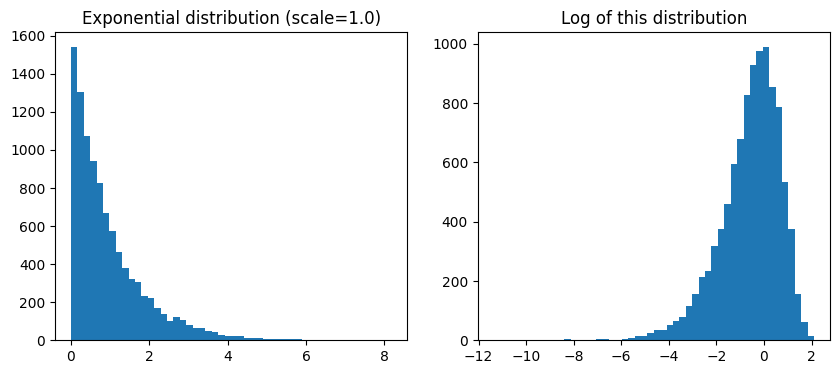

In [191]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

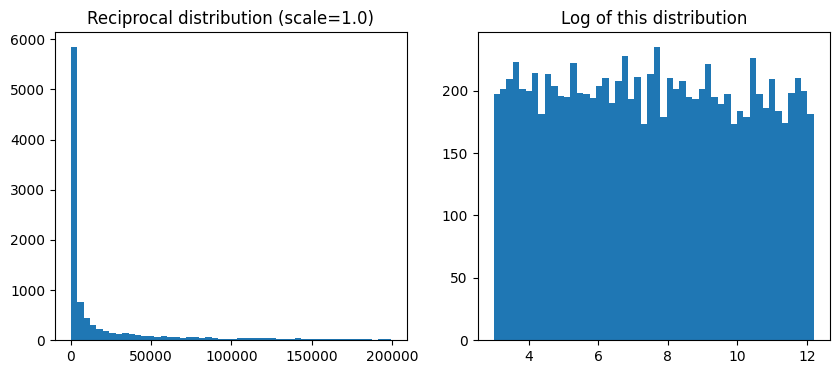

In [192]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

# Task 3 Try adding a transformer in the preparation pipeline to select only the most important attributes

In [193]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [194]:
result = permutation_importance(
    best_estimator,
    X_train,
    y_train,
    n_repeats=3,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)
feature_importances = result.importances_mean

In [195]:
k = 5 # Let's define the number of top features we want to keep:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([3, 4, 5, 6, 7])

In [196]:
full_pipeline.fit(X_train)

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
num_attribs = full_pipeline.named_transformers_["num"].named_steps["attribs_adder"].get_feature_names_out(num_attribs)

attributes = list(num_attribs) + cat_attribs + extra_attribs

top_features = np.array(attributes)[top_k_feature_indices]

In [206]:
top_features

array(['total_rooms', 'total_bedrooms', 'population', 'households',
       'median_income'], dtype='<U18')

Evaluate Your System on the Test Set

In [201]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f'Final RMSE: {final_rmse}')

Final RMSE: 66988.54451739727


# Task 4 - Try creating a single pipeline that does the full data preparation plus the final prediction.

In [203]:
svr_params = {k.replace('svr__', ''): v for k, v in rnd_search.best_params_.items()}

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**svr_params))
])

prepare_select_and_predict_pipeline.fit(X_train, y_train)

,steps,"[('preparation', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [204]:
some_data = X_test.iloc[:4]
some_labels = y_test.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [427512.10376993 236402.38143643 224923.02310059 150125.29061745]
Labels:		 [500001.0, 162500.0, 204600.0, 159700.0]


# Task 5. Automatically explore some preparation options using GridSearchCV

In [207]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline,
                                param_grid,
                                cv=cv,
                                scoring='neg_mean_squared_error',
                                verbose=0,
                                n_jobs=-1,
                                return_train_score=False)
grid_search_prep.fit(X_train, y_train)

C:\Users\username\Projects\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,estimator,Pipeline(step...l='linear'))])
,param_grid,"[{'feature_selection__k': [1, 2, ...], 'preparation__num__imputer__strategy': ['mean', 'median', ...]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [208]:
grid_search_prep.best_params_

{'feature_selection__k': 9, 'preparation__num__imputer__strategy': 'mean'}